## Random Strings based on a given REGEX

In [3]:
import random
import exrex

def rand_blocks(len=2, regex="[a-z]{3}:\\d{3}"):
    return

exrex.getone('[a-z]{5}-([a-z]|\\d){3}-[A-Z]{3}-\\d{3}')

'uftkc-cif-MAN-291'

## Distribution of NULL values

In [ ]:
import pandas as pd
import random
import numpy as np
import geopandas as gpd
import os
import exrex

df = pd.DataFrame({"x" : [random.randint(0,100) for x in range(100)], "y":[random.randint(200,300) for y in range(100)]})

def distribute_nans(df, percent=[5,10]):
    if isinstance(percent, list): 
        nan_prop = [round(np.floor(df.size * (x/100))) for x in percent]
    else:
        nan_prop = round(np.floor(df.size * (percent/100)))

    for i, prop in enumerate(nan_prop):
        df_temp = df.iloc[:,i:i+1].sample(frac=1)
        print(df_temp.iloc[0:prop, :].apply(lambda x: np.nan, axis=1))
        print(df_temp)
    return

def distribute_nans(df, percent=[5,10]):
    if isinstance(percent, list): 
        print(df.size)
        nan_prop = [round(len(df) * (x/100)) for x in percent]
        print(nan_prop)
    else:
        nan_prop = round(len(df) * (percent/100))
        print(nan_prop)

    for i, prop in enumerate(nan_prop):       
        change = df.iloc[:,i:i+1].sample(frac=1).index[0:prop]
        df.iloc[change, i:i+1] = np.nan
        df.sort_index()
    return df

df_nan = distribute_nans(df)

print(df_nan)



200
[5, 90]
       x      y
0   14.0    NaN
1   43.0    NaN
2   98.0    NaN
3   11.0    NaN
4   73.0    NaN
..   ...    ...
95  33.0    NaN
96  46.0    NaN
97   3.0  247.0
98   6.0    NaN
99  85.0    NaN

[100 rows x 2 columns]


## Improved GDF to SQL functionality

In [249]:
import geopandas as gpd
import os

def get_var_type(var_type):
    if var_type == 'int':
        return "INTEGER"
    elif var_type == 'str':
        return "VARCHAR"
    elif var_type == 'regex':
        return "VARCHAR"
    elif var_type == 'ts':
        return "TIMESTAMP"

def gdf_to_sql(table_name, gdf, random_var, rand_var_types, rand_var_names, extra_var, extra_var_types, extra_var_name, extra_var_dict, directory):
    
    # Opens up an SQL file based on the table name, writes to the file and closes it
    sqlFile = open(f'{directory}/SQL/{table_name}.sql', "w")
    sqlFile.write("")
    sqlFile.close()

    # Opens up the SQL file to append lines to it
    sqlFile = open(f'{directory}/SQL/{table_name}.sql', "a")

    # SQL statments to create the table as well as drop if exists the table are appended
    sqlFile.write('-- This is an automatically generated SQL table. This has been generated by the RADIAN tool (developer Mr. Paddy Gorry)\n\n')

    sqlFile.write('DROP TABLE IF EXISTS {}; \n\n'.format(table_name))

    sqlFile.write('CREATE TABLE {} ( \n'.format(table_name))
    sqlFile.write('\tpkid SERIAL PRIMARY KEY NOT NULL, \n')
    sqlFile.write("\tthegeom GEOMETRY DEFAULT ST_GeomFromText('POINT(0,51)', 4326)")

    if random_var:
        sqlFile.write(',\n')
        for count, type in enumerate(rand_var_types):
            sqlFile.write(f'\t{rand_var_names[count]} {get_var_type(rand_var_types[count])}')
            if count < len(rand_var_types)-1:
                sqlFile.write(', \n')

    if extra_var:
        for variable in extra_var_dict:
            create_query = f",\n\t{variable['name']} "
            if variable['type'] == 'str':
                create_query += 'VARCHAR'
            elif variable['type'] == 'regex':
                create_query += 'VARCHAR'
            elif variable['type'] == 'int':
                create_query += 'INTEGER'
            sqlFile.write(create_query)

    sqlFile.write('\n); \n\n')

    sqlFile.write('-- Spatial index is now created\n\n')

    # Creation of Spatial Index for the SQL file
    sqlFile.write('CREATE INDEX {}_spatial_index ON {} USING gist (thegeom); \n'.format(table_name, table_name))

    # Loop through every point in the GeoDataFrame to write an instert statement to append to the SQL file
    for row in gdf.iterrows():
        # Set 'y' value to Latitude and 'x' value to Longitude.
        print("geometry:", row[1][0])
        lat = row[1][0].y
        lon = row[1][0].x
        # Pull the randomly generated strings and ints from the dataframe
        if random_var:
            if (not extra_var):
                query = f"INSERT into {table_name} (thegeom, "
                for count, type in enumerate(rand_var_names):
                    query += f"{rand_var_names[count]}"
                    if count < len(rand_var_names)-1:
                        query += ", "
                query += f") VALUES (ST_SetSRID(ST_MakePoint({lon},{lat}), 4326), "
                for count, type in enumerate(rand_var_types):
                    # 19/11/2024 - adding in NULL functionality
                    current_value = row[1][count+1]
                    if np.isnan(current_value):
                        query += f'{current_value}'
                    else:
                        if type != "int":
                            query += "'"
                        query += f'{current_value}'
                        if type != "int":
                            query += "'"
                    if count < len(rand_var_names)-1:
                        query += ", "
                query += '); \r'           

            else:
                full_var_names = rand_var_names + extra_var_name
                full_var_types = rand_var_types + extra_var_types

                extra_values = []
                for i in range(len(extra_var_name)):
                    extra_values.append(row[1][len(rand_var_names)+i])

                query = f"INSERT into {table_name} (thegeom, "
                for count, type in enumerate(full_var_names):
                    query += f"{full_var_names[count]}"
                    if count < len(full_var_names)-1:
                        query += ", "
                query += f") VALUES (ST_SetSRID(ST_MakePoint({lon},{lat}), 4326), "
                for count, type in enumerate(full_var_types):
                    current_value = row[1][count+1]
                    if np.isnan(current_value):
                        query += f'{current_value}'
                    else:
                        if type != "int":
                            query += "'"
                    
                        if type == "str":
                            query += "{}".format(current_value.replace("'", "''")) 
                        else:
                            query += "{}".format(current_value)
                    
                        if type != "int":
                            query += "'"
                    if count < len(full_var_names)-1:
                        query += ", "
                query += '); \r'

        else:
            if(not extra_var):
                # Insert statement for each point along with the included variables
                query = "INSERT into {} (thegeom) VALUES (ST_SetSRID(ST_MakePoint({},{}),4326)); \r".format(
                    table_name, lon, lat)
            else:
                extra_values = []
                for i in range(len(extra_var_name)):
                    extra_values.append(row[1][i+1])

                var_index = 1
                query = f"INSERT into {table_name} (thegeom, "
                for count, type in enumerate(extra_var_name):
                    query += f"{extra_var_name[count]}"
                    if count < len(extra_var_name)-1:
                        query += ", "
                query += f") VALUES (ST_SetSRID(ST_MakePoint({lon},{lat}), 4326), "
                for count, type in enumerate(extra_var_types):
                    if type != "int":
                        query += "'"
                    
                    if type == "str":
                        query += "{}".format(row[1][count+1].replace("'", "''")) 
                    else:
                        query += "{}".format(row[1][count+1])
                    
                    if type != "int":
                        query += "'"
                    if count < len(extra_var_name)-1:
                        query += ", "
                query += '); \r'

        # Write query string to SQL file
        sqlFile.write(query)

directory = os.path.dirname("geojson_polygons/paris.geojson")

random_var = True
random_var_dict = [{"type":"int", "name": "housePrice", "params": [150000,2500000]},
			    {"type":"regex", "name": "postCode", "params": "[a-zA-Z]{2}\\d{5}"},
				{"type":"regex", "name": "energyRating", "params": "[A-F]"},
				{"type":"ts", "name": "surveyTime", "params": ["2022-01-01 00:00:00", "2025-12-31 23:59:59"] }]
rand_var_types = [var_dict["type"] for var_dict in random_var_dict]
rand_var_names = [var_dict["name"] for var_dict in random_var_dict]
rand_var_params = [var_dict["params"] for var_dict in random_var_dict]

extra_var = True
extra_var_dict = [{"type":"str", "name": "streetName", "source": "street_names.csv"}]
extra_var_types = [var_dict["type"] for var_dict in extra_var_dict]
extra_var_name = [var_dict["name"] for var_dict in extra_var_dict]

paris_null = gpd.read_file('/home/paddy/git/radian/geojson_polygons/GeoJSON/null_testing.geojson')
paris_null = paris_null[['PKID', 'geometry', 'housePrice', 'postCode', 'energyRating', 'surveyTime', 'streetName']]
gdf_to_sql("sql_revamp", paris_null, random_var, rand_var_types, rand_var_names, extra_var, extra_var_types, extra_var_name, extra_var_dict, directory)

print(paris_null)

geometry: 0


/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/tmp/ipykernel_9247/1202543704.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("geometry:", row[1][0])
/tmp/ipykernel_9247/1202543704.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lat = row[1][0].y


AttributeError: 'int' object has no attribute 'y'

In [144]:
import pandas as pd
import random
import numpy as np
import geopandas as gpd
import os
import exrex
import shapely

paris_null = gpd.read_file('/home/paddy/git/radian/geojson_polygons/GeoJSON/null_testing.geojson')
directory = os.path.dirname("geojson_polygons/paris.geojson")

def gdf_to_sql_new(gdf, table_name):

    ###### SQL BOILER PLATE ######
    
    # Opens up an SQL file based on the table name, writes to the file and closes it
    sqlFile = open(f'{directory}/SQL/{table_name}.sql', "w")
    sqlFile.write("")
    sqlFile.close()

    # Opens up the SQL file to append lines to it
    sqlFile = open(f'{directory}/SQL/{table_name}.sql', "a")

    # SQL statments to create the table as well as drop if exists the table are appended
    sqlFile.write('-- This is an automatically generated SQL table. This has been generated by the RADIAN tool (developer Mr. Paddy Gorry)\n\n')

    sqlFile.write('DROP TABLE IF EXISTS {}; \n\n'.format(table_name))

    sqlFile.write('CREATE TABLE {} ( \n'.format(table_name))
    sqlFile.write('\tpkid SERIAL PRIMARY KEY NOT NULL, \n')

    ###### BOILER PLATE ENDS ######

    def get_var_type(dtype):
        match dtype:
            case 'int64':
                return "INTEGER"
            case 'float64':
                return "REAL"
            case 'object':
                return "VARCHAR"
            case 'datetime64[ns]':
                return "TIMESTAMP"
            case 'geometry':
                return "GEOMETRY DEFAULT ST_GeomFromText('POINT(0,51)', 4326)"
            case _:
                return "NONE"    

    def ddl_column(col):
        return f"\t{col.name} {get_var_type(col.dtype)}"
        
    ###### DDL statements for creating variables from the gdf columns ######
    gdf.columns = ['thegeom' if x=='geometry' else x for x in gdf.columns]
    gdf_cols = [(gdf[gdf.columns[x]]) for x in range(1,len(gdf.columns))]

    # 'geometry' is not a valid column name for the SQL file, so we check and change this
    geom_col_name = [col.name for col in gdf_cols if col.dtype=='geometry'][0]

    # PKID serial has already been created
    for i, col in enumerate(gdf_cols):
        sqlFile.write("{}{}".format(ddl_column(col), (",\n" if i < len(gdf.columns)-2 else "\n);"))) #-2 since we omit the first column (pkid)

    sqlFile.write('\n\n-- Spatial index is now created\n\n')

    # Creation of Spatial Index for the SQL file
    sqlFile.write(f"CREATE INDEX {table_name}_spatial_index ON {table_name} USING gist ({geom_col_name}); \n")

    test_row = gdf.iloc[[0]]

        
    def val_format(val):
        if pd.isnull(val):
            return "null"
        return f"'{val}'"

    ###### DDL Insert Statements ######
    def write_insert(row):
        sqlFile.write(f"INSERT INTO {table_name} (")
        [sqlFile.write(f"{col}, ") if i < len(row.columns)-1 else sqlFile.write(f"{col}) VALUES (") for i, col in enumerate(row.columns) if i > 0]
        #[sqlFile.write(f"{val_format(val)}, ") if i < len(row.values[0])-1 else sqlFile.write(f"{val_format(val)});\n") for i, val in enumerate(row.values[0]) if i > 0]
        [sqlFile.write(f"{val_format(val)}, ") if i < len(row.values[0])-1 else sqlFile.write(f"{val_format(val)});\n") for i, val in enumerate(row.values[0]) if i > 0]

    [write_insert(gdf.iloc[i:i+1, :]) for i in range(len(gdf))]

gdf_to_sql_new(paris_null, "sql_test")


/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")


## Point Process implementation

### Uniform Generation

From the bellow testing, the original RADIAN uniform generation greatly outperforms the use of Point Processes, with regards to computation and speed. I think to use the existing implementation going forward, a more solid theoretical underpinning will be needed to better justify and quantify the use of this system.

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
import geopandas as gpd
import tempfile
import pandas as pd
import random

from shapely.geometry import box
from shapely.geometry import Polygon, Point, shape, GeometryCollection, LineString, LinearRing

from pointpats import PoissonPointProcess, PoissonClusterPointProcess, Window, poly_from_bbox, PointPattern
import libpysal as ps
from libpysal.cg import shapely_ext
from tqdm import tqdm

directory = os.path.dirname("geojson_polygons/paris.geojson")

def poly_bb_ratio(poly):
    min_x, min_y, max_x, max_y = poly.bounds
    bb = gpd.GeoSeries(box(min_x, min_y, max_x, max_y, ccw=True))
    ratio = float(1/(poly.area/bb.area))
    if ratio < 1.8:
        return 1.8
    return ratio

def points_uniform(poly, num_points):
    min_x, min_y, max_x, max_y = poly.bounds
    poly_ratio = poly_bb_ratio(poly)
    poly_gdf = gpd.GeoDataFrame(pd.DataFrame([poly], columns=['geometry']), geometry='geometry', crs=3857)

    points = []
    # Generates points repeatedly with a uniform generation within the bounds of the polygon
    while len(points) < round(num_points * poly_ratio):
        points.append(Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)]))
    gdf = gpd.GeoDataFrame(pd.DataFrame(points, columns=['geometry']), geometry='geometry', crs=3857)
    gdf = gdf.sjoin(poly_gdf, predicate='within')
    gdf = gdf.drop(['index_right'], axis=1)

    return gdf.iloc[0:num_points].reset_index(drop=True)

import warnings
warn_ignore = "Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal."
warnings.filterwarnings("ignore", message=warn_ignore)



def uniform_point_process(directory, num_points):
    gdf = gpd.read_file("geojson_polygons/glasgow.geojson")
    window = Window(gdf.geometry[0].exterior.coords)

    np.random.seed(5)
    samples = PoissonPointProcess(window, num_points, 1, conditioning=False, asPP=True)
    csr_points = samples.realizations[0]

    csr_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(csr_points.points['x'], csr_points.points['y']), crs=4326) 

    fig, ax = plt.subplots(figsize=(10,8))

    gdf.plot(ax=ax, edgecolor='black', facecolor='none')
    csr_gdf.plot(ax=ax, markersize=1, color='red')

def old_uniform(directory, num_points):
    gdf = gpd.read_file("geojson_polygons/glasgow.geojson")
    gdf_points = points_uniform(gdf.geometry[0], num_points)
    fig, ax = plt.subplots(figsize=(10,8))

    gdf.plot(ax=ax, edgecolor='black', facecolor='none')
    gdf_points.plot(ax=ax, markersize=1, color='red')




### Clustered

This has some decent functionality, however for instances where you may want to provide administrative boundaries/districts to influence the clustering behaviour, the Point Process implementation here doesn't allow for that. To get this you would need to go iterating by each district, and use an individual Point Process for each one, but our tests above show that our existing uniform generation outperforms this point process.

crs =  EPSG:3857


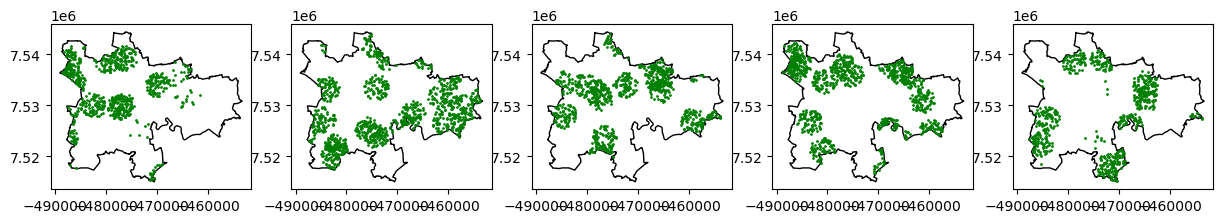

In [15]:
import matplotlib.pyplot as plt
import os
import numpy as np
import geopandas as gpd
import tempfile
import pandas as pd
import random

from shapely.geometry import box
from shapely.geometry import Polygon, Point, shape, GeometryCollection, LineString, LinearRing

from pointpats import PoissonPointProcess, PoissonClusterPointProcess, Window, poly_from_bbox, PointPattern
import libpysal as ps
from libpysal.cg import shapely_ext
from tqdm import tqdm

import warnings
warn_ignore = "Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal."
warnings.filterwarnings("ignore", message=warn_ignore)

gdf = gpd.read_file("geojson_polygons/glasgow.geojson").to_crs(3857)

print("crs = ", gdf.crs)
window = Window(gdf.geometry[0].exterior.coords)

csamples_a = PoissonClusterPointProcess(window, n=1000, parents=12, radius=2500, samples=5, asPP=True, conditioning=True)
cluster_points_a = csamples_a.realizations[0]

fig, axs = plt.subplots(1,5,figsize=(15,3))

for i, ax in enumerate(axs):
    gdf.plot(ax=ax, edgecolor='black', facecolor='none')
    cluster_a_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(csamples_a.realizations[i].points['x'], csamples_a.realizations[i].points['y']), crs=3857)
    cluster_a_gdf.plot(ax=ax, markersize=1, color='green')

## Time Comparisons

### Uniform

point process generation...


/tmp/ipykernel_14431/1562360219.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ratio = float(1/(poly.area/bb.area))
Generating points...:   0%|          | 0/1000 [03:17<?, ?it/s]

point process time =  32.28189015388489
old uniform generation...


old uniform time = 0.783193826675415


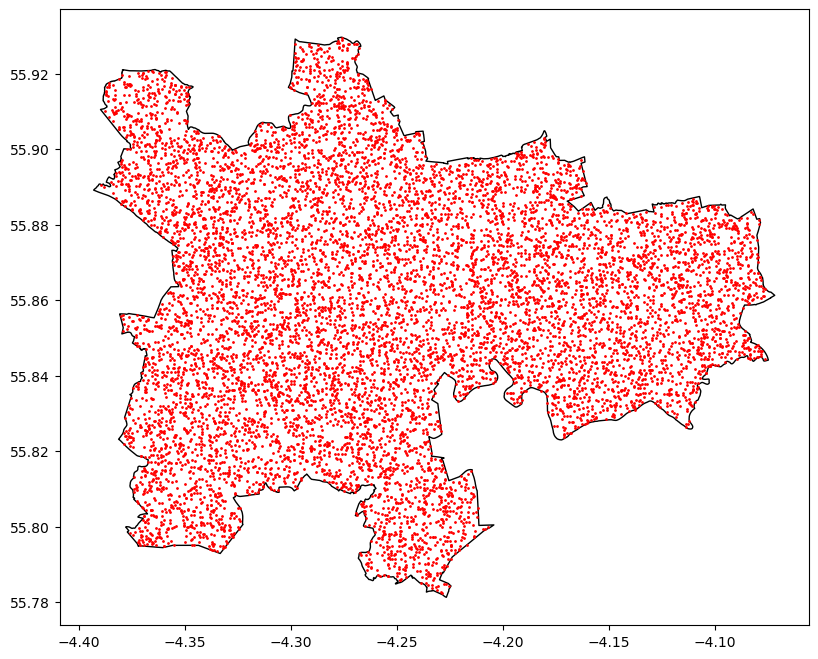

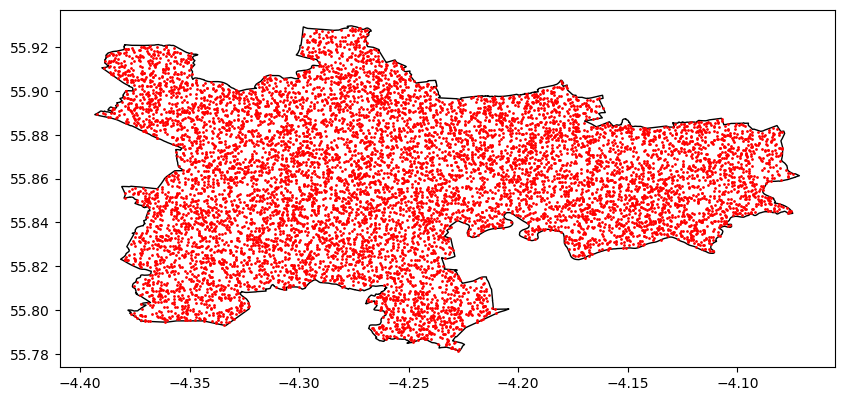

In [66]:
import time

test_points = 10000
print("point process generation...")

start = time.time()
uniform_point_process(directory, num_points=test_points)
end = time.time()

print("point process time = ", end-start)

print("old uniform generation...")
start = time.time()
old_uniform("dir", test_points)
end = time.time()

print("old uniform time =", end-start)

## Generating Polygons with Points

In [10]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
import shapely
import os.path
import time

from pathlib import Path
from shapely import voronoi_polygons, MultiPoint, unary_union
from shapely.ops import nearest_points
from sklearn.cluster import KMeans
from geovoronoi import voronoi_regions_from_coords, points_to_coords


org_dir = "geojson_polygons/dcc.geojson"
poi_dir = "geojson_polygons/geofabrik_dcc_bounding.geojson"

def bound_compare_voronoi(org_dir, poi_dir, epsg=3857, sample=0.1):
    start_time = time.time()
    
    # loading bounds and poi
    org_bounds = gpd.read_file(org_dir).to_crs(epsg)
    org_bounds.geometry = org_bounds.geometry.force_2d()
    poi = gpd.read_file(poi_dir).to_crs(epsg)
    poi = gpd.sjoin(poi, org_bounds)
    poi_sample = round(len(poi)*sample)

    # sampling poi
    poi = poi.sample(poi_sample) if sample < 1 else poi
    if poi_sample < len(org_bounds):
        print(f"poi sample ({poi_sample}) should be > number of original polygons ({len(org_bounds)})")
        print("adjust 'sample' and try again.")
        return
    
    # generating initial voronoi polygons
    boundary_shape = unary_union(org_bounds['geometry'])
    coords = points_to_coords(poi['geometry'])
    region_polys, _ = voronoi_regions_from_coords(coords, boundary_shape)
    poi_vor = gpd.GeoDataFrame(geometry=list(region_polys.values()), crs=epsg)

    # kmeans clustering for new voronoi centroids
    feature_coords = np.array([[e.x, e.y] for e in poi['geometry']])
    kmeans = KMeans(len(org_bounds['geometry']))
    kmeans.fit(feature_coords)
    centroids = kmeans.cluster_centers_
    df = pd.DataFrame(centroids, columns=['x', 'y'])
    poi_clust = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df.x, df.y), crs=3857)

    # classifying constituent voronoi by their distance to cluster centroids
    poi_vor['clust'] = poi_vor.geometry.centroid.apply(lambda g: poi_clust.geometry.distance(g)).apply(np.argmin, axis=1)
    poi_vor_clust = poi_vor.dissolve(by='clust')

    end_time = time.time()

    # plotting
    fig, axs = plt.subplots(1,2,figsize=(16,6), constrained_layout=True)
    fig.suptitle(f"{org_dir}\n{poi_sample} ({int(sample*100)}%) poi used\ntime taken: {end_time - start_time:.2f}s")
    for ax in axs:
        ax.axis('off')
        org_bounds.plot(ax=ax, facecolor='none', edgecolor='black')
        cx.add_basemap(ax, crs=3857, attribution=False)

    axs[0].set_title(f"true boundaries ({len(org_bounds)})")
    org_bounds.plot(ax=axs[0], facecolor='blue', edgecolor='white', alpha=0.7)

    axs[1].set_title(f"voronoi boundaries ({len(poi_vor_clust)})")
    poi_vor.plot(ax=axs[1], edgecolor='none', column='clust', cmap='viridis', alpha=0.7)
    poi_vor_clust.dissolve(by='clust').plot(ax=axs[1], facecolor='none', edgecolor='white')

    plt.show()

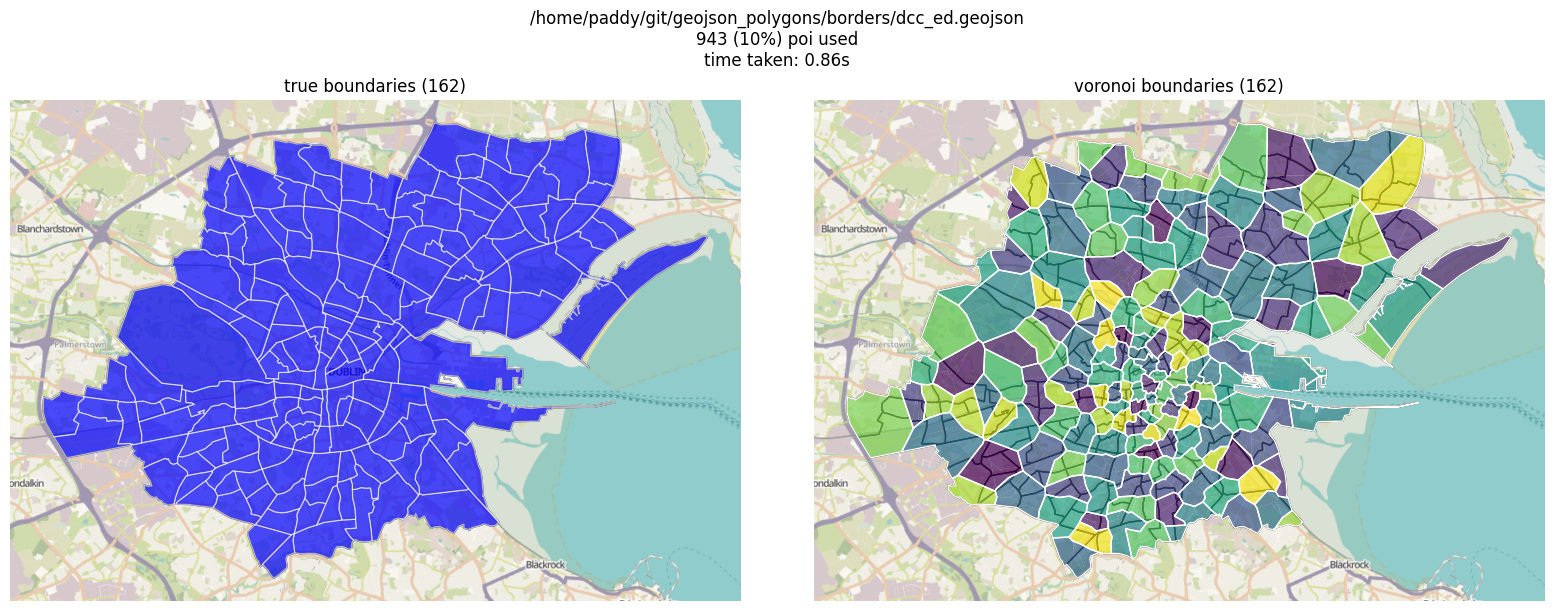

In [14]:
geojson_path = os.path.join(os.path.dirname(os.getcwd()), "geojson_polygons/borders")

dublin_bounds = os.path.join(geojson_path,"dcc_ed.geojson")
dublin_poi = os.path.join(geojson_path,"dublin_poi.geojson")

london_bounds = os.path.join(geojson_path,"london_wards.geojson")
london_poi = os.path.join(geojson_path,"london_poi.geojson")

ireland_bounds = os.path.join(geojson_path,"ireland_counties.geojson")
ireland_poi = os.path.join(geojson_path,"ireland_poi.geojson")

epsg = 3857

#for x in np.linspace(0.1,0.1,1):
bound_compare_voronoi(dublin_bounds, dublin_poi, epsg, 0.1)


In [ ]:
geojson_path = os.path.join(os.path.dirname(os.getcwd()), "geojson_polygons/borders")
ireland_bounds = os.path.join(geojson_path,"ireland_counties.geojson")

gdf = gpd.read_file(ireland_bounds)

# expand polygons and move to UTM geometry
polys = (
    gpd.GeoSeries(
        gdf.dropna()["geometry"].apply(lambda g: g.geoms).explode(), crs=gdf.crs
    )
    .to_crs(gdf.estimate_utm_crs())
    .simplify(100)
    .reset_index(drop=True)
)

# now build geodataframe limited by biggest area polygons
gdfm = (
    gpd.GeoDataFrame(data={"area": polys.area / 10**3}, geometry=polys, crs=polys.crs)
    .sort_values("area", ascending=0)
    # .head(3) # only one tasmania will be excluded
    .loc[lambda d: d["area"].gt(5000)]  # filter by size of polygon
    .reset_index()
)

# visualise
gdfm.explore(height=300, width=500)

## Testing out generating points within MultiPolygon input

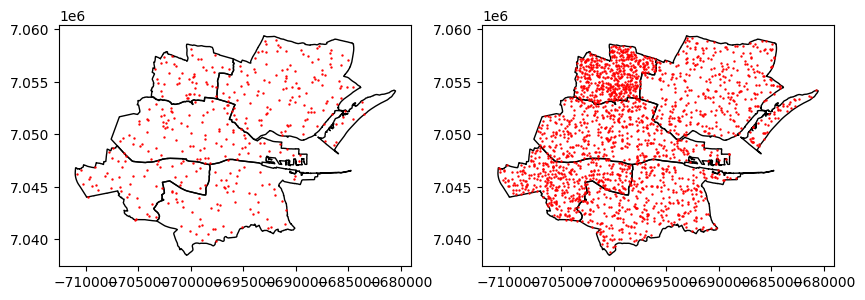

In [8]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
import shapely
import os.path
import time
import random

from pathlib import Path
from shapely import voronoi_polygons, Point, Polygon, MultiPolygon, MultiPoint, unary_union
from shapely.geometry import box
from shapely.ops import nearest_points
from sklearn.cluster import KMeans
from geovoronoi import voronoi_regions_from_coords, points_to_coords

geojson_path = os.path.join(os.path.dirname(os.getcwd()), "geojson_polygons/borders")
dcc = gpd.read_file(os.path.join(geojson_path, "dublin.geojson")).to_crs(3857)
dcc.geometry = dcc.geometry.force_2d()

def points_uniform(poly, num_points=100, epsg=3857):
    min_x, min_y, max_x, max_y = poly.bounds

    points = []
    while len(points) < round(num_points * 1.5):
        points.append(Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)]))
    gdf = gpd.GeoDataFrame(pd.DataFrame(points, columns=['geometry']), geometry='geometry', crs=3857)
    gdf = gdf.sjoin(gpd.GeoDataFrame(geometry=gpd.GeoSeries(poly), crs=epsg), predicate='within')
    gdf = gdf.drop(['index_right'], axis=1)

    return gdf.iloc[0:num_points].reset_index(drop=True)

def points_uniform_multi(poly_geoms, num_points=100, epsg=3857, even=False):
    gdf_out = gpd.GeoDataFrame(geometry=[], crs=3857)
    
    for geom in poly_geoms.geometry:
        gdf_out = pd.concat([gdf_out, points_uniform(geom, round(num_points * (1 if even else geom.area/poly_geoms.dissolve().area[0])))], ignore_index=True)     
    return gdf_out

test_gdf_a = points_uniform_multi(dcc, 500, 3857, False)
test_gdf_b = points_uniform_multi(dcc, 500, 3857, True)

fig, axs = plt.subplots(1,2, figsize=(10,8))

dcc.plot(ax=axs[0], edgecolor='black', facecolor='none')
dcc.plot(ax=axs[1], edgecolor='black', facecolor='none')

test_gdf_a.plot(ax=axs[0], color='red', markersize=0.5)
test_gdf_b.plot(ax=axs[1], color='red', markersize=0.5)

plt.show()

* Just assigning the same number of points to each polygon in the table of course results in the distirbution looking non-uniform as the polygons with smaller areas will have greater density. Would need to adjust the number of points per polygon based on area in cases like this.

In [8]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
import shapely
import os.path
import time

from pathlib import Path
from shapely import voronoi_polygons, MultiPoint, unary_union
from shapely.ops import nearest_points
from sklearn.cluster import KMeans
from geovoronoi import voronoi_regions_from_coords, points_to_coords

geojson_path = os.path.join(os.path.dirname(os.getcwd()), "geojson_polygons/borders")

lnd_wards = gpd.read_file(os.path.join(geojson_path, "london_wards.geojson")).to_crs(3857)
lnd_grid_250 = gpd.read_file(os.path.join(geojson_path, "london_poi_250m_grid.geojson")).to_crs(3857)
lnd_grid_250 = gpd.overlay(lnd_grid_250, lnd_wards, how='intersection').plot(ax=ax, edgecolor='blue')

lnd_poi = gpd.read_file(os.path.join(geojson_path, "london_named_poi.geojson")).to_crs(3857)
lnd_poi.geometry = lnd_poi.geometry.force_2d()

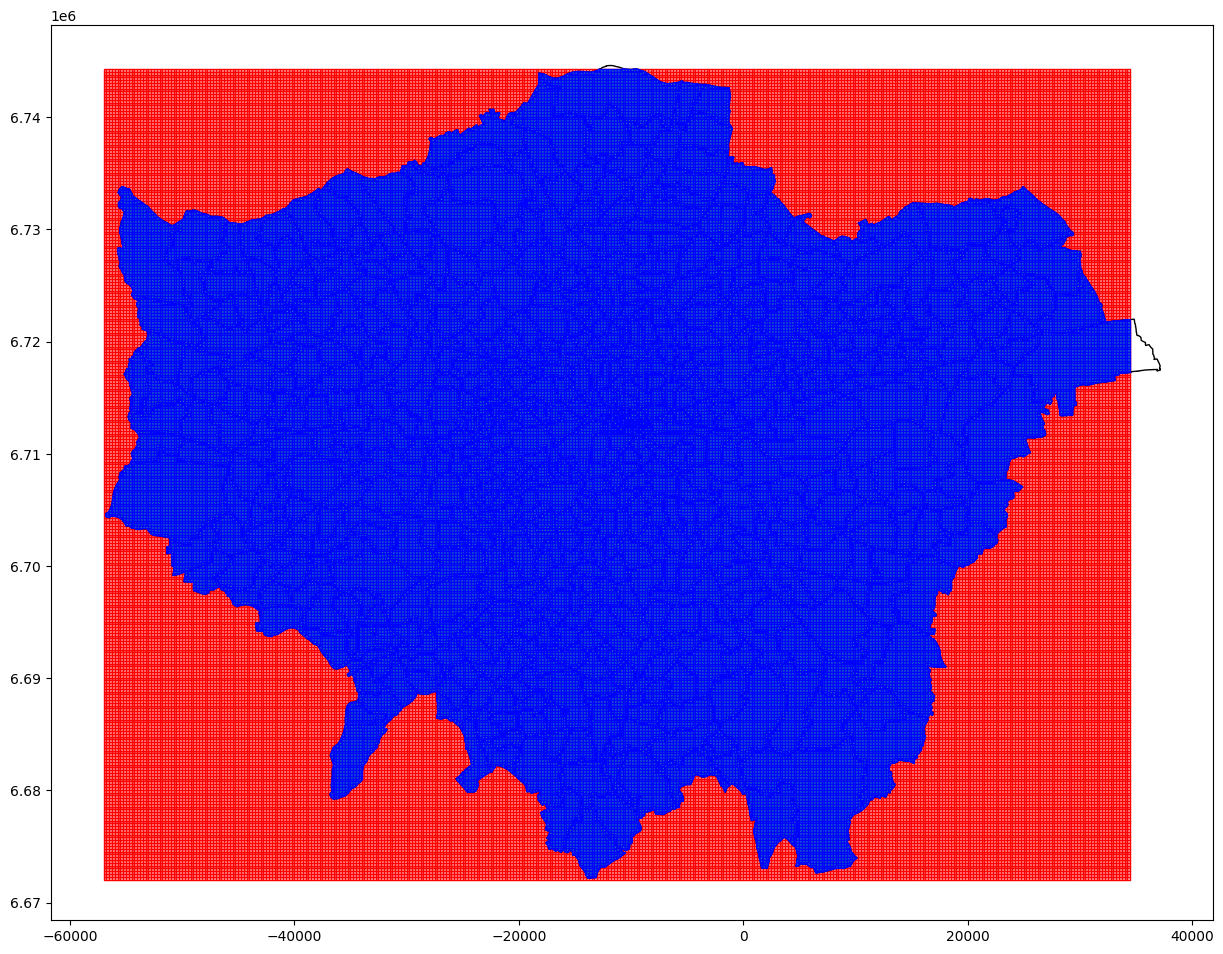

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,12))

#lnd_poi.plot(ax=ax, color='red', markersize=0.5)
lnd_grid_250.plot(ax=ax, edgecolor='red', facecolor='none')
lnd_wards.plot(ax=ax, facecolor='none', edgecolor='black')

plt.show()